# **DAVIDE BULOTTA ------ Assignment 2**

In [1]:
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image
from matplotlib import pyplot as plt
from torchvision import transforms
from torch.functional import F
from tqdm import tqdm
from PIL import Image
import torch.nn as nn
import numpy as np
import torch
import os

# Read Dataset

The image was read and collet using Pillow libray

For the model learning all image was converted in RGB matrix

In [2]:
def geImage(idx:int):
    # Read the image and mask
    img_name = 'dataset/horse/horse' + str(idx).zfill(3) + '.png'
    mask_name = 'dataset/mask/horse' + str(idx).zfill(3) + '.png'
    # Open the image and convert it to RGB
    # https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.open
    # https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.convert
    img = Image.open(img_name).convert('RGB')
    # Open the mask
    mask = Image.open(mask_name)
    return img, mask

All images was resized into 640 x 640 for the learning

I've used **torchvision.transforms** for the **resize**, **convert to tensor** and **normalize all images**

In [3]:
# Define the image size
size = (640, 640)

# Define the transformations
# I've used the v1 version of transforms
# https://pytorch.org/vision/stable/transforms.html
# https://pytorch.org/vision/stable/generated/torchvision.transforms.Resize.html#torchvision.transforms.Resize
# https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html#torchvision.transforms.ToTensor
# https://pytorch.org/vision/stable/generated/torchvision.transforms.Normalize.html#torchvision.transforms.Normalize
# https://pytorch.org/vision/stable/generated/torchvision.transforms.Lambda.html#torchvision.transforms.Lambda

preprocessing_image = transforms.Compose([
    # Resize the image
    transforms.Resize(size),
    # Convert the image to a tensor
    transforms.ToTensor(),
    # Normalize the image
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

preprocessing_mask = transforms.Compose([
    # Resize the mask
    transforms.Resize(size),
    # Convert the mask to a tensor
    transforms.ToTensor(),
    # Convert the mask to a binary mask
    transforms.Lambda(lambda x: (x > 0).float()),
])

I've splitted for the dataset in 75%/25%

In [4]:
# Create the lists to store the images and masks
images_list = []
masks_list = []

# Loop over the images
for idx in tqdm(range(1,328), desc='Preparing iamge dataset'): # 1-327
    img, mask = geImage(idx)
    if img is not None:
        img = preprocessing_image(img)
        images_list.append(img)
    if mask is not None:
        mask = preprocessing_mask(mask)
        masks_list.append(mask)

Preparing iamge dataset: 100%|██████████| 327/327 [00:02<00:00, 109.84it/s]


In [5]:
# Stack the images and masks
train_images = torch.stack(images_list[:246])
train_masks = torch.stack(masks_list[:246])
test_images = torch.stack(images_list[246:])
test_masks = torch.stack(masks_list[246:])

In [6]:
# Create the dataset
train_dataset = TensorDataset(train_images, train_masks)
test_dataset = TensorDataset(test_images, test_masks)
# Create the dataloader
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

# The Convolutional Network

After much indecision, I decided to implement a ResNet-50 by applying a Fully Convolutional Network (FCN) to it.

The reasons for this decision were varied:

&emsp; - Personal interest in implementing a commonly used network like ResNet-50.

&emsp; - A desire to work with a network that relies solely on convolutions, making it suitable for better understanding this type of architecture.

&emsp; - The flexibility to modify the network, allowing changes from ResNet-50 to ResNet-101 or ResNet-152.

&emsp; - An opportunity to gain a deeper understanding of how an FCN can be applied to a ResNet.

In particular my ispiration was follow the fcn_resnet50-101 implemented by [pytorch](https://pytorch.org/hub/pytorch_vision_fcn_resnet101/)

For the implementation of this model I've studied from the slide adding different resources online

&emsp; - [Fully Convolutional Network (Semantic Segmentation)](https://towardsdatascience.com/review-fcn-semantic-segmentation-eb8c9b50d2d1)

&emsp; - [Converting FC Layers to Conv Layers](https://mein2work.medium.com/converting-fc-layers-to-conv-layers-8a43880a44ed)

&emsp; - [Weakly-Labelled Semantic Segmentation of Fish Objects in Underwater Videos Using a Deep Residual Network](https://www.researchgate.net/publication/314071170_Weakly-Labelled_Semantic_Segmentation_of_Fish_Objects_in_Underwater_Videos_Using_a_Deep_Residual_Network) (For fun)

## BasicBlock

In [7]:
# Define the basic block class for the ResNet
class BasicBlock(nn.Module):
    # The expansion is used to increase the number of channels
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        # The first convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        # The batch normalization layer
        self.bn1 = nn.BatchNorm2d(out_channels)
        # The second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        # The batch normalization layer
        self.bn2 = nn.BatchNorm2d(out_channels)
        # The third convolutional layer
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, bias=False)
        # The batch normalization layer
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        # The ReLU layer
        self.relu = nn.ReLU(inplace=True)
        # The downsample layer is used to match the dimensions between the residual and the output
        self.downsample = downsample
        
    def forward(self, x):
        # Save the residual
        residual = x
        # If the downsample is not None, apply it
        if self.downsample is not None:
            residual = self.downsample(x)
        # Apply the first convolutional layer
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        # Apply the second convolutional layer
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        # Apply the third convolutional layer
        out = self.conv3(out)
        out = self.bn3(out)
        # Add the residual to the output
        out += residual
        out = self.relu(out)
        return out

## ResNet

The ResNet model serves as a powerful backbone for feature extraction in the Fully Convolutional Network (FCN) application.

It utilizes **residual** learning through residual blocks, which help in learning complex features by enabling direct gradient flow through skip connections.

**Max Pooling** is applied early in the network, right after the initial convolution layer.

In [8]:
# Define the ResNet model
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1):
        super(ResNet, self).__init__()
        # The number of input channels
        self.in_channels = 64
        # The first convolutional layer of the ResNet
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # The batch normalization layer of the ResNet
        self.bn = nn.BatchNorm2d(64)
        # The ReLU layer of the ResNet
        self.relu = nn.ReLU(inplace=True)
        # The maxpool layer of the ResNet
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # The layer1 of the ResNet
        self.layer1 = self.make_layer(block, 64, layers[0])
        # The layer2 of the ResNet
        self.layer2 = self.make_layer(block, 128, layers[1], 2)
        # The layer3 of the ResNet
        self.layer3 = self.make_layer(block, 256, layers[2], 2)
        # The layer4 of the ResNet
        self.layer4 = self.make_layer(block, 512, layers[3], 2)

    # Define the make_layer function to create the layers of the ResNet
    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None

        # Check if the input channels is not equal to the output channels
        if stride != 1 or self.in_channels != out_channels * block.expansion: # 64 != 64 * 4 
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion)
            ) # 1x1 conv layer
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample)) # 1st layer
        # Update the input channels
        self.in_channels = out_channels * block.expansion
        # Create the remaining layers
        for i in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # Apply the first step in the ResNet
        x = self.conv1(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.maxpool(x)
        # Apply the layer1
        layer1_output = self.layer1(x)
        # Apply the layer2 using the output of layer1
        layer2_output = self.layer2(layer1_output)
        # For FNC ResNet50, we need to save the output of layer3 and layer4
        layer3_output = self.layer3(layer2_output)
        layer4_output = self.layer4(layer3_output)
        # Return the output of layer4 and layer3 for the FNC ResNet50
        return layer4_output, layer3_output

## FCN ResNet

The **FCN Head** is crucial for transforming the high-dimensional feature maps extracted by the backbone into a lower-dimensional space.

I've used a standard convolutional layer with a dropout function to reduce the overfitting problem and after another convolution to remap the tensor into the output class.


In [9]:
# FNC ResNet50 model
class FCNHead(nn.Sequential):
    def __init__(self, in_channels, channels, number_of_classes=1):
        # The layers of the FCN head
        layers = [
            nn.Conv2d(in_channels, channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Conv2d(channels, number_of_classes, kernel_size=1)
        ]
        super(FCNHead, self).__init__(*layers)

## FCN (Fully Convolutional Networks)

The FCN (Fully Convolutional Network) model is designed to handle image segmentation tasks by converting the feature maps from the ResNet backbone into pixel-wise classification outputs.


In [10]:
class FCN(nn.Module):
    def __init__(self, backbone, classifier, aux_classifier=None):
        super(FCN, self).__init__()
        self.backbone = backbone
        self.classifier = classifier
        self.aux_classifier = aux_classifier

    def forward(self, x):
        # Get the input shape of the image x
        input_shape = x.shape[-2:]
        features, aux_features = self.backbone(x)
        # Get the output
        x = self.classifier(features)
        # Resize the output to the input shape
        x = F.interpolate(x, size=input_shape, mode='bilinear', align_corners=False)

        result = {"out": x}

        if self.aux_classifier is not None:
            # Get the auxiliary output
            aux = self.aux_classifier(aux_features)
            # Resize the output to the input shape
            aux = F.interpolate(aux, size=input_shape, mode='bilinear', align_corners=False)
            result["aux"] = aux

        return result

In [11]:
# 
def FCNResNet101(num_classes=1, aux=True):
    #backbone = ResNet(BasicBlock, [3, 4, 6, 3]) # ResNet50
    backbone = ResNet(BasicBlock, [3, 4, 23, 3]) # ResNet101
    #backbone = ResNet(BasicBlock, [3, 8, 36, 3]) # ResNet152
    classifier = FCNHead(2048, 512, num_classes)
    aux_classifier = FCNHead(1024, 256, num_classes) if aux else None
    model = FCN(backbone, classifier, aux_classifier)
    return model

In [12]:
# Create the model
model = FCNResNet101()

In [13]:
#output = model(input_tensor)
#print(output)

In [14]:
# Count the number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [15]:
model_parameters = count_parameters(model)
print(f"Model parameters: {model_parameters}")

Model parameters: 54298946


In [16]:
onnx_file_path = "model.onnx"
model = model.to('cuda:0')
model.eval()
input_tensor = torch.randn(1, 3, 224, 224).cuda()
# Export the model
torch.onnx.export(
    model,                      # Pytorch model
    input_tensor,               # Input tensor
    onnx_file_path,             # Output file path
    export_params=True,         # Export the trained parameters
    opset_version=11,           # Version of the ONNX opset to use
    do_constant_folding=True,   # Execute constant folding for optimization
    input_names=['input'],      # Names of the input
    output_names=['output'],    # Names of the output
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}} # Dynamic axes
)

In [17]:
print(model)

FCN(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0):

In [18]:
def dice_coefficient(y_true, y_pred, epsilon=1e-6):
    y_true = y_true.float()
    y_pred = y_pred.float()
    
    intersection = torch.sum(y_true * y_pred)
    union = torch.sum(y_true) + torch.sum(y_pred)
    
    dice = (2. * intersection + epsilon) / (union + epsilon)
    
    return dice

In [19]:
def bestModelCheck(dice, loss, bestDice, bestLoss):
    bestScore = bestDice + bestLoss / 2
    score = dice + loss / 2
    if score > bestScore:
        return True

In [20]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
#criterion = nn.MSELoss()
criterion = nn.BCEWithLogitsLoss()
numb_epochs = 100

# Best model parameters
bestDice = 0.0
bestModel = None
bestEpoch = 0

loss_train = []
dice_train = []
loss_test = []
dice_test = []
for epoch in tqdm(range(1, numb_epochs+1)):
    model.train()
    loss_epoch = 0.0
    dice_epoch = 0.0
    for images, masks in train_loader:
        images = images.cuda()
        masks = masks.cuda()
        #
        output = model(images)['out']
        loss = criterion(output, masks)
        #
        binary_output = torch.sigmoid(output) > 0.5  # Binarizzazione dei logits
        dice = dice_coefficient(masks, binary_output)
        #
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #
        loss_epoch += loss.item()
        dice_epoch += dice.item()
        #
    loss_epoch /= len(train_loader)
    dice_epoch /= len(train_loader)
    loss_train.append(loss_epoch)
    dice_train.append(dice_epoch)

    model.eval()
    loss_epoch = 0.0
    dice_epoch = 0.0
    with torch.no_grad():
        for images, masks in test_loader:
            images = images.cuda()
            masks = masks.cuda()
            #
            output = model(images)['out']
            loss = criterion(output, masks)
            #
            binary_output = torch.sigmoid(output) > 0.5  # Binarizzazione dei logits
            dice = dice_coefficient(masks, binary_output)
            #
            loss_epoch += loss.item()
            dice_epoch += dice.item()
            #
        loss_epoch /= len(test_loader)
        dice_epoch /= len(test_loader)
        # Check if the model is the best
        if dice_epoch > bestDice:
            bestDice = dice_epoch
            bestModel = model
            bestEpoch = epoch
        #
        loss_test.append(loss_epoch)
        dice_test.append(dice_epoch)
        
    print(f"Epoch: {epoch}, Loss Train: {loss_train[-1]:.4f}, Dice Train: {dice_train[-1]:.4f}, Loss Test: {loss_test[-1]:.4f}, Dice Test: {dice_test[-1]:.4f}")

  1%|          | 1/100 [00:07<13:06,  7.95s/it]

Epoch: 1, Loss Train: 0.5430, Dice Train: 0.0206, Loss Test: 222.4563, Dice Test: 0.0000


  2%|▏         | 2/100 [00:15<12:48,  7.84s/it]

Epoch: 2, Loss Train: 0.4420, Dice Train: 0.0024, Loss Test: 0.4716, Dice Test: 0.0000


  3%|▎         | 3/100 [00:23<12:35,  7.79s/it]

Epoch: 3, Loss Train: 0.4141, Dice Train: 0.4147, Loss Test: 0.6116, Dice Test: 0.2730


  4%|▍         | 4/100 [00:31<12:32,  7.84s/it]

Epoch: 4, Loss Train: 0.3938, Dice Train: 0.6026, Loss Test: 0.5215, Dice Test: 0.4276


  5%|▌         | 5/100 [00:39<12:23,  7.83s/it]

Epoch: 5, Loss Train: 0.3846, Dice Train: 0.5950, Loss Test: 1.0268, Dice Test: 0.1449


  6%|▌         | 6/100 [00:47<12:17,  7.85s/it]

Epoch: 6, Loss Train: 0.3633, Dice Train: 0.6450, Loss Test: 0.7446, Dice Test: 0.0323


  7%|▋         | 7/100 [00:54<12:09,  7.85s/it]

Epoch: 7, Loss Train: 0.3487, Dice Train: 0.6601, Loss Test: 0.4402, Dice Test: 0.2378


  8%|▊         | 8/100 [01:02<12:03,  7.87s/it]

Epoch: 8, Loss Train: 0.3282, Dice Train: 0.6913, Loss Test: 0.3812, Dice Test: 0.5555


  9%|▉         | 9/100 [01:10<11:56,  7.87s/it]

Epoch: 9, Loss Train: 0.3166, Dice Train: 0.7073, Loss Test: 0.3800, Dice Test: 0.5723


 10%|█         | 10/100 [01:18<11:50,  7.90s/it]

Epoch: 10, Loss Train: 0.3056, Dice Train: 0.7205, Loss Test: 0.3700, Dice Test: 0.5442


 11%|█         | 11/100 [01:26<11:32,  7.79s/it]

Epoch: 11, Loss Train: 0.2985, Dice Train: 0.7298, Loss Test: 0.3926, Dice Test: 0.4871


 12%|█▏        | 12/100 [01:33<11:20,  7.73s/it]

Epoch: 12, Loss Train: 0.2833, Dice Train: 0.7457, Loss Test: 0.3536, Dice Test: 0.6158


 13%|█▎        | 13/100 [01:41<11:05,  7.65s/it]

Epoch: 13, Loss Train: 0.2778, Dice Train: 0.7471, Loss Test: 0.3336, Dice Test: 0.5924


 14%|█▍        | 14/100 [01:48<10:55,  7.62s/it]

Epoch: 14, Loss Train: 0.2720, Dice Train: 0.7564, Loss Test: 0.3139, Dice Test: 0.7307


 15%|█▌        | 15/100 [01:56<10:45,  7.60s/it]

Epoch: 15, Loss Train: 0.2628, Dice Train: 0.7634, Loss Test: 0.3034, Dice Test: 0.7491


 16%|█▌        | 16/100 [02:03<10:37,  7.59s/it]

Epoch: 16, Loss Train: 0.2542, Dice Train: 0.7730, Loss Test: 0.3141, Dice Test: 0.7066


 17%|█▋        | 17/100 [02:11<10:27,  7.56s/it]

Epoch: 17, Loss Train: 0.2456, Dice Train: 0.7806, Loss Test: 0.2726, Dice Test: 0.7793


 18%|█▊        | 18/100 [02:19<10:21,  7.58s/it]

Epoch: 18, Loss Train: 0.2276, Dice Train: 0.7986, Loss Test: 0.2784, Dice Test: 0.7500


 19%|█▉        | 19/100 [02:26<10:13,  7.57s/it]

Epoch: 19, Loss Train: 0.2301, Dice Train: 0.7945, Loss Test: 0.3064, Dice Test: 0.6995


 20%|██        | 20/100 [02:34<10:05,  7.56s/it]

Epoch: 20, Loss Train: 0.2173, Dice Train: 0.8089, Loss Test: 0.2596, Dice Test: 0.7813


 21%|██        | 21/100 [02:41<09:57,  7.56s/it]

Epoch: 21, Loss Train: 0.2058, Dice Train: 0.8182, Loss Test: 0.2709, Dice Test: 0.7770


 22%|██▏       | 22/100 [02:49<09:49,  7.55s/it]

Epoch: 22, Loss Train: 0.2091, Dice Train: 0.8141, Loss Test: 0.2701, Dice Test: 0.7900


 23%|██▎       | 23/100 [02:56<09:40,  7.54s/it]

Epoch: 23, Loss Train: 0.2009, Dice Train: 0.8209, Loss Test: 0.2579, Dice Test: 0.7910


 24%|██▍       | 24/100 [03:04<09:31,  7.53s/it]

Epoch: 24, Loss Train: 0.1976, Dice Train: 0.8244, Loss Test: 0.4313, Dice Test: 0.4176


 25%|██▌       | 25/100 [03:11<09:26,  7.55s/it]

Epoch: 25, Loss Train: 0.1874, Dice Train: 0.8371, Loss Test: 0.2338, Dice Test: 0.8129


 26%|██▌       | 26/100 [03:19<09:20,  7.58s/it]

Epoch: 26, Loss Train: 0.1759, Dice Train: 0.8457, Loss Test: 0.2537, Dice Test: 0.7723


 27%|██▋       | 27/100 [03:27<09:11,  7.56s/it]

Epoch: 27, Loss Train: 0.1772, Dice Train: 0.8447, Loss Test: 0.2378, Dice Test: 0.8151


 28%|██▊       | 28/100 [03:34<09:03,  7.55s/it]

Epoch: 28, Loss Train: 0.1665, Dice Train: 0.8567, Loss Test: 0.2167, Dice Test: 0.8368


 29%|██▉       | 29/100 [03:42<08:55,  7.54s/it]

Epoch: 29, Loss Train: 0.1611, Dice Train: 0.8593, Loss Test: 0.2255, Dice Test: 0.8087


 30%|███       | 30/100 [03:49<08:48,  7.55s/it]

Epoch: 30, Loss Train: 0.1591, Dice Train: 0.8622, Loss Test: 0.2485, Dice Test: 0.7960


 31%|███       | 31/100 [03:57<08:39,  7.54s/it]

Epoch: 31, Loss Train: 0.1515, Dice Train: 0.8672, Loss Test: 0.2165, Dice Test: 0.8372


 32%|███▏      | 32/100 [04:04<08:30,  7.51s/it]

Epoch: 32, Loss Train: 0.1396, Dice Train: 0.8787, Loss Test: 0.2156, Dice Test: 0.8344


 33%|███▎      | 33/100 [04:12<08:23,  7.52s/it]

Epoch: 33, Loss Train: 0.1349, Dice Train: 0.8831, Loss Test: 0.2332, Dice Test: 0.8246


 34%|███▍      | 34/100 [04:19<08:15,  7.51s/it]

Epoch: 34, Loss Train: 0.1443, Dice Train: 0.8722, Loss Test: 0.2379, Dice Test: 0.8363


 35%|███▌      | 35/100 [04:27<08:08,  7.51s/it]

Epoch: 35, Loss Train: 0.1376, Dice Train: 0.8807, Loss Test: 0.2141, Dice Test: 0.8401


 36%|███▌      | 36/100 [04:34<07:59,  7.50s/it]

Epoch: 36, Loss Train: 0.1313, Dice Train: 0.8852, Loss Test: 0.2242, Dice Test: 0.8466


 37%|███▋      | 37/100 [04:42<07:55,  7.55s/it]

Epoch: 37, Loss Train: 0.1290, Dice Train: 0.8879, Loss Test: 0.3888, Dice Test: 0.7319


 38%|███▊      | 38/100 [04:50<07:54,  7.65s/it]

Epoch: 38, Loss Train: 0.1340, Dice Train: 0.8847, Loss Test: 0.2584, Dice Test: 0.8136


 39%|███▉      | 39/100 [04:58<07:50,  7.72s/it]

Epoch: 39, Loss Train: 0.1186, Dice Train: 0.8977, Loss Test: 0.2208, Dice Test: 0.8426


 40%|████      | 40/100 [05:05<07:44,  7.75s/it]

Epoch: 40, Loss Train: 0.1067, Dice Train: 0.9072, Loss Test: 0.2050, Dice Test: 0.8586


 41%|████      | 41/100 [05:13<07:36,  7.74s/it]

Epoch: 41, Loss Train: 0.0996, Dice Train: 0.9136, Loss Test: 0.2443, Dice Test: 0.8408


 42%|████▏     | 42/100 [05:21<07:27,  7.71s/it]

Epoch: 42, Loss Train: 0.0972, Dice Train: 0.9155, Loss Test: 0.2169, Dice Test: 0.8466


 43%|████▎     | 43/100 [05:28<07:15,  7.64s/it]

Epoch: 43, Loss Train: 0.0968, Dice Train: 0.9156, Loss Test: 0.3155, Dice Test: 0.7740


 44%|████▍     | 44/100 [05:36<07:04,  7.59s/it]

Epoch: 44, Loss Train: 0.1006, Dice Train: 0.9124, Loss Test: 0.2771, Dice Test: 0.8144


 45%|████▌     | 45/100 [05:43<06:56,  7.57s/it]

Epoch: 45, Loss Train: 0.0952, Dice Train: 0.9165, Loss Test: 0.2315, Dice Test: 0.8457


 46%|████▌     | 46/100 [05:51<06:48,  7.56s/it]

Epoch: 46, Loss Train: 0.1139, Dice Train: 0.9026, Loss Test: 0.2485, Dice Test: 0.8385


 47%|████▋     | 47/100 [05:58<06:39,  7.54s/it]

Epoch: 47, Loss Train: 0.1118, Dice Train: 0.9028, Loss Test: 0.2757, Dice Test: 0.8051


 48%|████▊     | 48/100 [06:06<06:30,  7.52s/it]

Epoch: 48, Loss Train: 0.1014, Dice Train: 0.9116, Loss Test: 0.1889, Dice Test: 0.8639


 49%|████▉     | 49/100 [06:13<06:24,  7.54s/it]

Epoch: 49, Loss Train: 0.0912, Dice Train: 0.9202, Loss Test: 0.2158, Dice Test: 0.8526


 50%|█████     | 50/100 [06:21<06:16,  7.54s/it]

Epoch: 50, Loss Train: 0.0852, Dice Train: 0.9249, Loss Test: 0.2456, Dice Test: 0.8381


 51%|█████     | 51/100 [06:28<06:09,  7.54s/it]

Epoch: 51, Loss Train: 0.0790, Dice Train: 0.9303, Loss Test: 0.2243, Dice Test: 0.8568


 52%|█████▏    | 52/100 [06:36<06:01,  7.54s/it]

Epoch: 52, Loss Train: 0.0768, Dice Train: 0.9316, Loss Test: 0.2383, Dice Test: 0.8576


 53%|█████▎    | 53/100 [06:43<05:54,  7.54s/it]

Epoch: 53, Loss Train: 0.0757, Dice Train: 0.9327, Loss Test: 0.2756, Dice Test: 0.8535


 54%|█████▍    | 54/100 [06:51<05:46,  7.54s/it]

Epoch: 54, Loss Train: 0.0734, Dice Train: 0.9348, Loss Test: 0.2984, Dice Test: 0.8475


 55%|█████▌    | 55/100 [06:58<05:38,  7.52s/it]

Epoch: 55, Loss Train: 0.0706, Dice Train: 0.9375, Loss Test: 0.2410, Dice Test: 0.8668


 56%|█████▌    | 56/100 [07:06<05:29,  7.50s/it]

Epoch: 56, Loss Train: 0.0692, Dice Train: 0.9381, Loss Test: 0.2614, Dice Test: 0.8591


 57%|█████▋    | 57/100 [07:13<05:22,  7.50s/it]

Epoch: 57, Loss Train: 0.0669, Dice Train: 0.9402, Loss Test: 0.3892, Dice Test: 0.7916


 58%|█████▊    | 58/100 [07:21<05:14,  7.50s/it]

Epoch: 58, Loss Train: 0.0694, Dice Train: 0.9379, Loss Test: 0.2437, Dice Test: 0.8641


 59%|█████▉    | 59/100 [07:28<05:07,  7.51s/it]

Epoch: 59, Loss Train: 0.0689, Dice Train: 0.9385, Loss Test: 0.2341, Dice Test: 0.8755


 60%|██████    | 60/100 [07:36<05:00,  7.51s/it]

Epoch: 60, Loss Train: 0.0679, Dice Train: 0.9395, Loss Test: 0.2481, Dice Test: 0.8620


 61%|██████    | 61/100 [07:43<04:52,  7.51s/it]

Epoch: 61, Loss Train: 0.0661, Dice Train: 0.9407, Loss Test: 0.2405, Dice Test: 0.8680


 62%|██████▏   | 62/100 [07:51<04:45,  7.50s/it]

Epoch: 62, Loss Train: 0.0662, Dice Train: 0.9406, Loss Test: 0.2284, Dice Test: 0.8623


 63%|██████▎   | 63/100 [07:58<04:37,  7.51s/it]

Epoch: 63, Loss Train: 0.0667, Dice Train: 0.9398, Loss Test: 0.2065, Dice Test: 0.8714


 64%|██████▍   | 64/100 [08:06<04:30,  7.50s/it]

Epoch: 64, Loss Train: 0.0645, Dice Train: 0.9419, Loss Test: 0.2041, Dice Test: 0.8825


 65%|██████▌   | 65/100 [08:13<04:22,  7.49s/it]

Epoch: 65, Loss Train: 0.0596, Dice Train: 0.9466, Loss Test: 0.2407, Dice Test: 0.8744


 66%|██████▌   | 66/100 [08:21<04:15,  7.52s/it]

Epoch: 66, Loss Train: 0.0564, Dice Train: 0.9495, Loss Test: 0.2770, Dice Test: 0.8717


 67%|██████▋   | 67/100 [08:29<04:08,  7.54s/it]

Epoch: 67, Loss Train: 0.0533, Dice Train: 0.9518, Loss Test: 0.2486, Dice Test: 0.8772


 68%|██████▊   | 68/100 [08:36<04:01,  7.54s/it]

Epoch: 68, Loss Train: 0.0523, Dice Train: 0.9527, Loss Test: 0.2775, Dice Test: 0.8717


 69%|██████▉   | 69/100 [08:44<03:53,  7.53s/it]

Epoch: 69, Loss Train: 0.0519, Dice Train: 0.9526, Loss Test: 0.2836, Dice Test: 0.8700


 70%|███████   | 70/100 [08:51<03:45,  7.53s/it]

Epoch: 70, Loss Train: 0.0521, Dice Train: 0.9525, Loss Test: 0.2800, Dice Test: 0.8719


 71%|███████   | 71/100 [08:59<03:38,  7.55s/it]

Epoch: 71, Loss Train: 0.0538, Dice Train: 0.9509, Loss Test: 0.2891, Dice Test: 0.8702


 72%|███████▏  | 72/100 [09:06<03:31,  7.55s/it]

Epoch: 72, Loss Train: 0.0573, Dice Train: 0.9476, Loss Test: 0.3258, Dice Test: 0.8522


 73%|███████▎  | 73/100 [09:14<03:24,  7.56s/it]

Epoch: 73, Loss Train: 0.0604, Dice Train: 0.9455, Loss Test: 0.2835, Dice Test: 0.8560


 74%|███████▍  | 74/100 [09:21<03:16,  7.57s/it]

Epoch: 74, Loss Train: 0.0588, Dice Train: 0.9472, Loss Test: 0.2549, Dice Test: 0.8692


 75%|███████▌  | 75/100 [09:29<03:09,  7.59s/it]

Epoch: 75, Loss Train: 0.0588, Dice Train: 0.9466, Loss Test: 0.2493, Dice Test: 0.8728


 76%|███████▌  | 76/100 [09:37<03:02,  7.60s/it]

Epoch: 76, Loss Train: 0.0600, Dice Train: 0.9451, Loss Test: 0.2548, Dice Test: 0.8692


 77%|███████▋  | 77/100 [09:44<02:55,  7.62s/it]

Epoch: 77, Loss Train: 0.0597, Dice Train: 0.9459, Loss Test: 0.2454, Dice Test: 0.8710


 78%|███████▊  | 78/100 [09:52<02:48,  7.65s/it]

Epoch: 78, Loss Train: 0.0566, Dice Train: 0.9487, Loss Test: 0.2716, Dice Test: 0.8692


 79%|███████▉  | 79/100 [10:00<02:40,  7.66s/it]

Epoch: 79, Loss Train: 0.0528, Dice Train: 0.9522, Loss Test: 0.2490, Dice Test: 0.8817


 80%|████████  | 80/100 [10:07<02:32,  7.64s/it]

Epoch: 80, Loss Train: 0.0493, Dice Train: 0.9552, Loss Test: 0.2750, Dice Test: 0.8803


 81%|████████  | 81/100 [10:15<02:25,  7.67s/it]

Epoch: 81, Loss Train: 0.0475, Dice Train: 0.9569, Loss Test: 0.2979, Dice Test: 0.8703


 82%|████████▏ | 82/100 [10:23<02:18,  7.68s/it]

Epoch: 82, Loss Train: 0.0466, Dice Train: 0.9574, Loss Test: 0.2619, Dice Test: 0.8811


 83%|████████▎ | 83/100 [10:31<02:11,  7.75s/it]

Epoch: 83, Loss Train: 0.0464, Dice Train: 0.9574, Loss Test: 0.2434, Dice Test: 0.8827


 84%|████████▍ | 84/100 [10:38<02:03,  7.74s/it]

Epoch: 84, Loss Train: 0.0480, Dice Train: 0.9560, Loss Test: 0.2694, Dice Test: 0.8743


 85%|████████▌ | 85/100 [10:46<01:55,  7.70s/it]

Epoch: 85, Loss Train: 0.0505, Dice Train: 0.9535, Loss Test: 0.2751, Dice Test: 0.8742


 86%|████████▌ | 86/100 [10:54<01:47,  7.68s/it]

Epoch: 86, Loss Train: 0.0505, Dice Train: 0.9540, Loss Test: 0.3058, Dice Test: 0.8681


 87%|████████▋ | 87/100 [11:01<01:40,  7.70s/it]

Epoch: 87, Loss Train: 0.0494, Dice Train: 0.9551, Loss Test: 0.3048, Dice Test: 0.8691


 88%|████████▊ | 88/100 [11:09<01:31,  7.65s/it]

Epoch: 88, Loss Train: 0.0481, Dice Train: 0.9561, Loss Test: 0.2649, Dice Test: 0.8797


 89%|████████▉ | 89/100 [11:16<01:23,  7.60s/it]

Epoch: 89, Loss Train: 0.0471, Dice Train: 0.9569, Loss Test: 0.2639, Dice Test: 0.8713


 90%|█████████ | 90/100 [11:24<01:15,  7.56s/it]

Epoch: 90, Loss Train: 0.1255, Dice Train: 0.9012, Loss Test: 196.9257, Dice Test: 0.3466


 91%|█████████ | 91/100 [11:31<01:07,  7.54s/it]

Epoch: 91, Loss Train: 0.1990, Dice Train: 0.8354, Loss Test: 5.1093, Dice Test: 0.8032


 92%|█████████▏| 92/100 [11:39<01:00,  7.53s/it]

Epoch: 92, Loss Train: 0.1502, Dice Train: 0.8724, Loss Test: 0.2755, Dice Test: 0.7403


 93%|█████████▎| 93/100 [11:47<00:52,  7.56s/it]

Epoch: 93, Loss Train: 0.1296, Dice Train: 0.8898, Loss Test: 0.1671, Dice Test: 0.8707


 94%|█████████▍| 94/100 [11:54<00:45,  7.58s/it]

Epoch: 94, Loss Train: 0.1172, Dice Train: 0.9007, Loss Test: 0.3799, Dice Test: 0.7183


 95%|█████████▌| 95/100 [12:02<00:38,  7.63s/it]

Epoch: 95, Loss Train: 0.1022, Dice Train: 0.9124, Loss Test: 0.1729, Dice Test: 0.8735


 96%|█████████▌| 96/100 [12:10<00:30,  7.68s/it]

Epoch: 96, Loss Train: 0.0977, Dice Train: 0.9159, Loss Test: 0.2165, Dice Test: 0.8580


 97%|█████████▋| 97/100 [12:17<00:23,  7.67s/it]

Epoch: 97, Loss Train: 0.0818, Dice Train: 0.9292, Loss Test: 0.1950, Dice Test: 0.8777


 98%|█████████▊| 98/100 [12:25<00:15,  7.66s/it]

Epoch: 98, Loss Train: 0.0729, Dice Train: 0.9362, Loss Test: 0.2042, Dice Test: 0.8799


 99%|█████████▉| 99/100 [12:33<00:07,  7.66s/it]

Epoch: 99, Loss Train: 0.0655, Dice Train: 0.9422, Loss Test: 0.2076, Dice Test: 0.8812


100%|██████████| 100/100 [12:40<00:00,  7.61s/it]

Epoch: 100, Loss Train: 0.0605, Dice Train: 0.9465, Loss Test: 0.2482, Dice Test: 0.8715


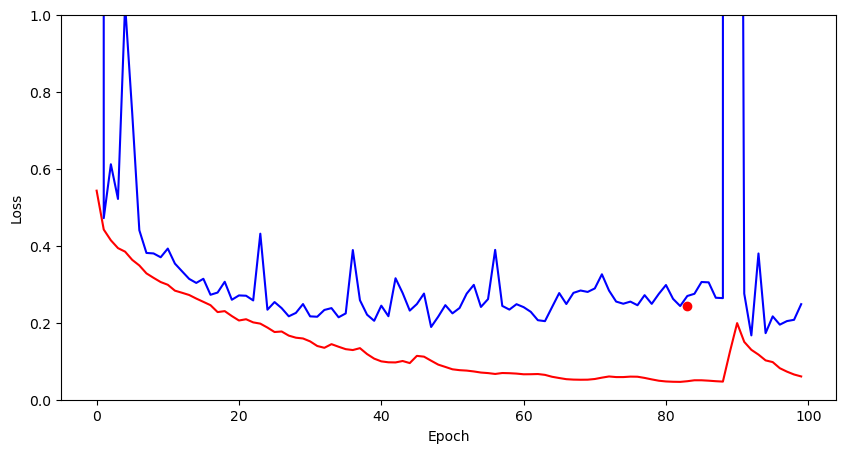

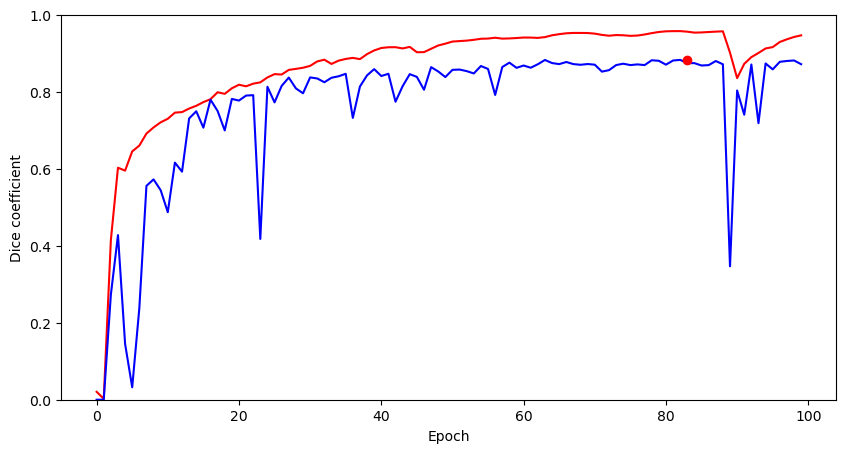

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(loss_train, label='Train', color='red')
plt.plot(loss_test, label='Test', color='blue')
plt.plot(bestEpoch, loss_test[bestEpoch-1], 'ro')
plt.xlabel('Epoch')
plt.ylim(0, 1)
plt.ylabel('Loss')
plt.legend
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(dice_train, label='Train', color='red')
plt.plot(dice_test, label='Test', color='blue')
plt.plot(bestEpoch, dice_test[bestEpoch-1], 'ro')
plt.xlabel('Epoch')
plt.ylim(0, 1)
plt.ylabel('Dice coefficient')
plt.legend
plt.show()

In [22]:
model = bestModel # Setting the best model

In [23]:
def predict_image(model, image, mask):
    model.eval()
    with torch.no_grad():
        output = model(image.unsqueeze(0))['out']
        output = output.squeeze(0).squeeze(0)
        output = torch.sigmoid(output)
        output = output.cpu().numpy()
    
    binary_output = (output > 0.5).astype(int)
    true_mask = mask.squeeze().cpu().numpy()

    fig, ax = plt.subplots(1, 3, figsize=(12, 6))
    ax[0].imshow(image.cpu().permute(1, 2, 0))  # Da tensor a immagine
    ax[0].set_title("Original Image")
    ax[1].imshow(binary_output, cmap='gray')  # Visualizza la maschera predetta
    ax[1].set_title("Predicted Mask")
    ax[2].imshow(true_mask, alpha=0.5, cmap='gray')  # Visualizza la maschera vera
    ax[2].set_title("True Mask")
    plt.show()

## Train images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


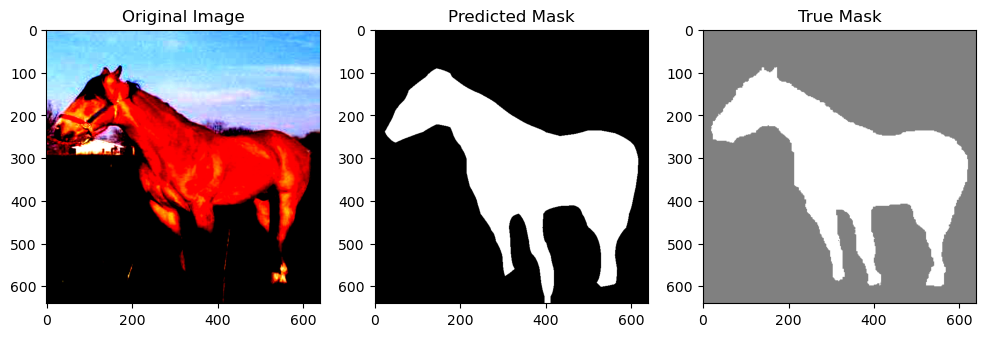

In [24]:
idx = 19
image = train_images[idx]
mask = train_masks[idx]
image = image.cuda()
predict_image(model, image, mask)

## Test images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


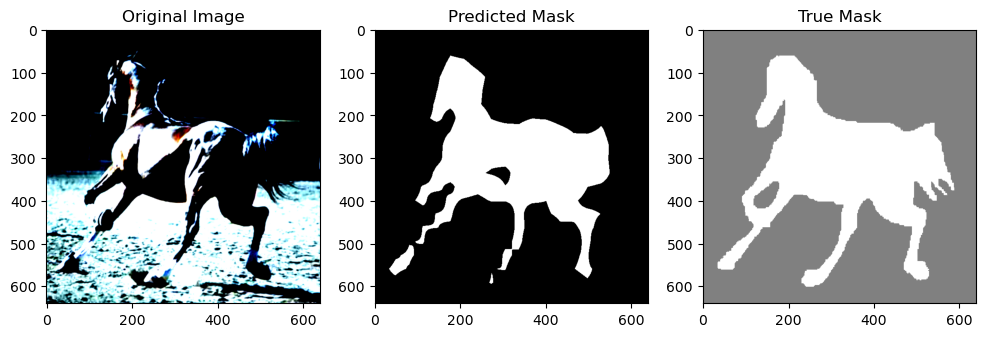

In [25]:
idxs = 19
image = test_images[idx]
mask = test_masks[idx]
image = image.cuda()
predict_image(model, image, mask)

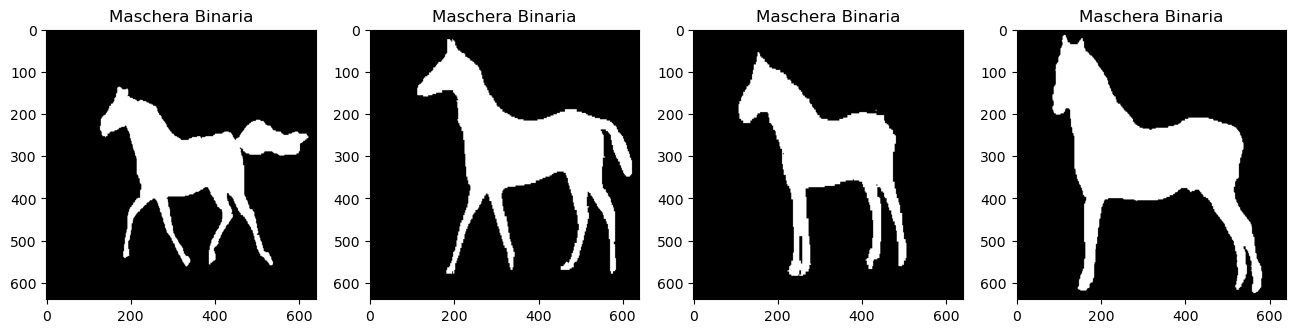

In [26]:
def visualize_masks(masks):
    fig, ax = plt.subplots(1, 4, figsize=(16, 4))
    for i in range(4):
        ax[i].imshow(masks[i].cpu().numpy().squeeze(), cmap='gray')
        ax[i].set_title("Maschera Binaria")
    plt.show()

# Visualizza alcune maschere di addestramento
visualize_masks(train_masks)